In [47]:
import csv
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance
from collections import Counter

# 1.Analysis of the relationship between the child's age and other characteristics on comprehension and production
# 1.1Read the data and analyse it quantitatively.

### Handling nan values

In [48]:
data = pd.read_csv("wordbank_administration_data.csv")
# First, remove the values in the first column, as this column is meaningless.
data=data.drop(columns='downloaded') 
drop_list=[]
for i in data.columns.values:
    tmp=data["{}".format(i)]
    is_null=tmp.isnull().any()
    is_null_all=tmp.isnull().all()
    if is_null:
        if is_null_all:
            print("warning!! All nan values in the attribute '{}' need to be deleted!!!".format(i))
            data=data.drop(columns='{}'.format(i)) # 
            print("This column has been deleted!")
        else:
            print("There are nan values in the '{}' attribute that need to be processed!".format(i))
data.reset_index(drop=True, inplace=True)

There are nan values in the 'birth_order' attribute that need to be processed!
There are nan values in the 'caregiver_education' attribute that need to be processed!
There are nan values in the 'ethnicity' attribute that need to be processed!
There are nan values in the 'race' attribute that need to be processed!
There are nan values in the 'sex' attribute that need to be processed!
warning!! All nan values in the attribute 'birth_weight' need to be deleted!!!
This column has been deleted!
warning!! All nan values in the attribute 'born_early_or_late' need to be deleted!!!
This column has been deleted!
warning!! All nan values in the attribute 'gestational_age' need to be deleted!!!
This column has been deleted!
warning!! All nan values in the attribute 'zygosity' need to be deleted!!!
This column has been deleted!
warning!! All nan values in the attribute 'language_exposures' need to be deleted!!!
This column has been deleted!
There are nan values in the 'health_conditions' attribute 

D:\Anaconda\envs\PYTORCH_new\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (11,12,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [49]:
data

,language,form,dataset_name,child_id,age,comprehension,production,is_norming,birth_order,caregiver_education,ethnicity,race,sex,health_conditions,monolingual,typically_developing
0,Croatian,WG,CLEX,18186,13,293,88,True,NaN,NaN,NaN,NaN,Female,NaN,True,True
1,Croatian,WG,CLEX,18187,16,122,12,True,NaN,NaN,NaN,NaN,Male,NaN,True,True
2,Croatian,WG,CLEX,18188,9,3,0,True,NaN,NaN,NaN,NaN,Female,NaN,True,True
3,Croatian,WG,CLEX,18189,12,0,0,True,NaN,NaN,NaN,NaN,Female,NaN,True,True
4,Croatian,WG,CLEX,18190,12,44,0,True,NaN,NaN,NaN,NaN,Female,NaN,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90892,Portuguese (European),WG,Cadime,66175,14,162,11,False,NaN,College,NaN,NaN,Female,NaN,True,True
90893,Portuguese (European),WG,Cadime,66176,15,314,47,False,NaN,Primary,NaN,NaN,Female,NaN,True,True
90894,Portuguese (European),WG,Cadime,66177,15,103,15,False,NaN,College,NaN,NaN,Female,NaN,True,True
90895,Portuguese (European),WG,Cadime,66178,15,256,24,False,NaN,Graduate,NaN,NaN,Male,NaN,True,True


In [50]:
print("There are now {} rows and {} columns.".format(data.shape[0],data.shape[1]))

There are now 90897 rows and 16 columns.


<AxesSubplot:>

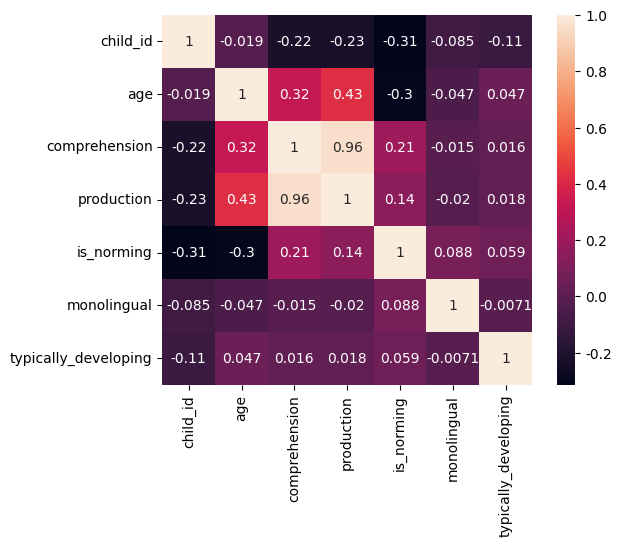

In [51]:
# Correlation analysis of the data. The closer the value to 1, the higher the correlation.
import matplotlib.pyplot as plt
figure, ax = plt.subplots()
sns.heatmap(data.corr(), square=True, annot=True, ax=ax)
#It is clear from this diagram that comprehension, production and age are very closely related.

## 1.2 Analysis of the meaning and scope of the data on a case-by-case basis

In [52]:
columns_values=data.columns.values
print(columns_values)

['language' 'form' 'dataset_name' 'child_id' 'age' 'comprehension'
 'production' 'is_norming' 'birth_order' 'caregiver_education' 'ethnicity'
 'race' 'sex' 'health_conditions' 'monolingual' 'typically_developing']


1.Language, related to the topic, see how many in total. Pie chart analysis.

There are a total38 of language attributes, and their data share relationship is shown below.
The relationship of the data of the language attribute is as follows: Counter({'English (British)': 23129, 'English (American)': 12124, 'Norwegian': 12029, 'Danish': 6112, 'Portuguese (European)': 4326, 'Turkish': 3537, 'Mandarin (Taiwanese)': 2654, 'Spanish (Mexican)': 2278, 'Dutch': 2063, 'Korean': 1989, 'Mandarin (Beijing)': 1938, 'Russian': 1805, 'Slovak': 1716, 'English (Australian)': 1497, 'French (Quebecois)': 1467, 'Italian': 1400, 'Swedish': 1367, 'Cantonese': 1208, 'German': 1181, 'Spanish (European)': 1005, 'French (French)': 863, 'Spanish (Argentinian)': 783, 'Latvian': 683, 'Croatian': 627, 'Hebrew': 565, 'Czech': 493, 'Hungarian': 372, 'Finnish': 238, 'Kigiriama': 207, 'Spanish (Peruvian)': 192, 'Greek (Cypriot)': 176, 'American Sign Language': 171, 'Persian': 163, 'British Sign Language': 161, 'Kiswahili': 130, 'Irish': 99, 'English (Irish)': 99, 'Spanish (Chilean)': 50})


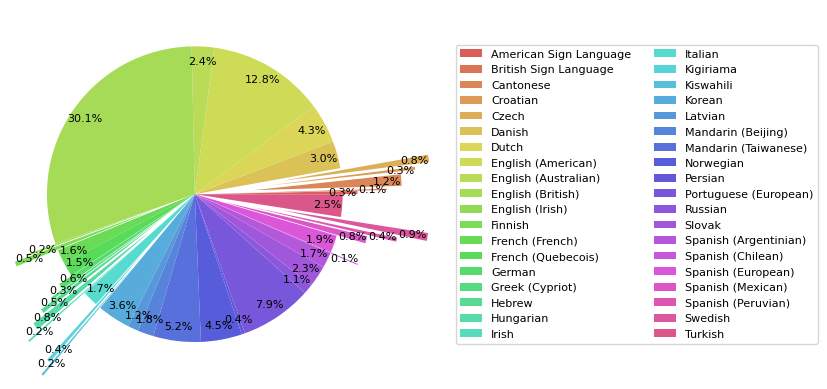

In [53]:
analytic_attribute=columns_values[0]
language_values=np.unique(data['{}'.format(analytic_attribute)])
print("There are a total{} of {} attributes, and their data share relationship is shown below.".format(len(language_values),analytic_attribute))
print("The relationship of the data of the {} attribute is as follows:".format(analytic_attribute),Counter(data['{}'.format(analytic_attribute)]))

# Analysis by child id and category of language
# import matplotlib.pyplot as plt               
distance=np.zeros(len(language_values)) #This is an extension of the overlapping attributes to the outer part
# for i in range(len(distance)):
    # distance[i]=0+0.005*(i+1)
distance[4]=0.6
distance[3]=0.5
distance[2]=0.4
distance[1]=0.3
distance[0]=0.1

distance[36]=0.6
distance[35]=0.4
distance[34]=0.2

distance[32]=0.2

distance[21]=0.6
distance[20]=0.5

distance[18]=0.5
distance[17]=0.4
distance[16]=0.3
distance[15]=0.2
distance[14]=0.1

distance[11]=0.3
distance[10]=0.2
colors = sns.color_palette("hls", 40) #Colour bar
plt.rcParams['font.sans-serif'] = ['Times New Romans']  
plt.rcParams['axes.unicode_minus'] = False    
date=data
date = date.set_index('language')                 
# date.index = pd.to_datetime(date.index)       
result = date[['child_id']].groupby(date.index).sum()          
plt.pie(result['child_id'], labels=result.index,labeldistance=None, autopct='%1.1f%%',pctdistance=0.9,colors=colors,textprops={'color':'black', 'size':8, },explode=distance) 
# plt.title('')  
plt.legend(loc="right",prop={'size':8},ncol=2,bbox_to_anchor=(2.2,0.5))
# plt.savefig("csv1.png",dpi=1200, bbox_inches='tight')
plt.savefig("csv1.png",dpi=1200, bbox_inches='tight')
plt.show()

#The analysis shows that English (British) clearly has a large share.

2.form

In [54]:
# The data vary too much, unifying those with too few numbers into one category.
index=[]
result_num=[]
other=0
for n in range(len(result['child_id'])):
#     print(n)
    if result['child_id'][n] <20000000:
#         print(result['child_id'][n])
        other+=result['child_id'][n]
    else:
        index.append(result.index[n])
        result_num.append(result['child_id'][n])
index.append("other")
result_num.append(other)

There are a totalform of 19 attributes, and their data share relationship is shown below.
The relationship of the data is as follows： Counter({'WS': 45682, 'WG': 18792, 'TEDS Twos': 11129, 'TEDS Threes': 10790, 'Oxford CDI': 1210, 'TC': 652, 'WGShort': 547, 'FormOne': 392, 'FormTwoB': 374, 'FormTwoA': 332, 'Swingley': 268, 'WSShort': 231, 'IC': 230, 'CDITwo': 110, 'FormThree': 97, 'FormBOne': 19, 'FormBTwo': 19, 'FormC': 17, 'FormA': 6})


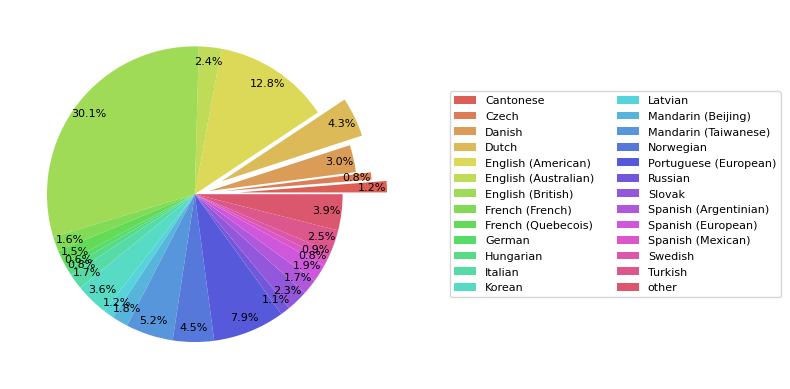

In [55]:
analytic_attribute=columns_values[1]
values=np.unique(data['{}'.format(analytic_attribute)])
print("There are a total{} of {} attributes, and their data share relationship is shown below.".format(analytic_attribute,len(values)))
print("The relationship of the data is as follows：",Counter(data['{}'.format(analytic_attribute)]))

num=Counter(data['{}'.format(analytic_attribute)])


colors = sns.color_palette("hls", len(result_num))
plt.rcParams['font.sans-serif'] = ['Times New Romans']  
plt.rcParams['axes.unicode_minus'] = False   
date=data
date = date.set_index('form')  

distance=np.zeros(len(result_num)) 
distance[0]=0.3
distance[1]=0.2
distance[2]=0.1
distance[3]=0.2

# date.index = pd.to_datetime(date.index)      
result = date[['child_id']].groupby(date.index).sum()         
plt.pie(result_num, labels=index,labeldistance=None, autopct='%1.1f%%',pctdistance=0.9,colors=colors,textprops={'color':'black', 'size':8, },explode=distance)  
# plt.title('')  
plt.legend(loc="right",prop={'size':8},ncol=2,bbox_to_anchor=(2.1,0.5))
# plt.savefig("csv1.png",dpi=1200, bbox_inches='tight')
# plt.savefig("csv1.png",dpi=1200, bbox_inches='tight')
plt.show()

4.dataset_name 

In [56]:
dataset_name_values=np.unique(data['dataset_name'])
print("There are a total{} of {} attributes, and their data share relationship is shown below.".format(len(dataset_name_values),"dataset_name"))
print("The relationship of the data is as follows：",Counter(data['dataset_name']))

There are a total46 of dataset_name attributes, and their data share relationship is shown below.
The relationship of the data is as follows： Counter({'TEDS': 21919, 'Kristoffersen': 12029, 'CLEX': 11023, 'Marchman': 10070, 'Cadime': 4326, 'Bleses': 3714, 'Liu': 2654, 'Bergman': 2063, 'Tardif': 2043, 'Kapalkova': 1716, 'Pae': 1700, 'Kalashnikova': 1497, 'Smith': 1420, 'Thal': 1298, 'Floccia': 1210, 'Szagun': 1181, 'Karousou': 1005, 'Li': 882, 'Trudeau': 827, 'Resches': 783, 'Caselli': 758, 'Urek': 683, 'Walle': 610, 'Shalev': 540, 'Kern': 522, 'Smolik': 493, 'Edgin': 435, 'Kas': 372, 'Alcock': 337, 'Hoff': 295, 'Yim': 289, 'VonHolzen': 284, 'Poulin-Dubois': 243, 'Stolt': 238, 'Nazzi': 221, 'OToole': 198, 'Blume': 192, 'Grohmann': 176, 'Kazemi': 163, 'Woll': 161, 'Fernald': 82, 'Byers': 68, 'Bergmann': 57, 'Navarro': 50, 'Frank': 37, 'Armon-Lotem': 33})


There are a total41 of age attributes, and their data share relationship is shown below.
The relationship of the data is as follows： Counter({24: 10349, 36: 6055, 23: 5816, 35: 4681, 18: 4162, 25: 4063, 16: 4045, 28: 3441, 17: 3312, 19: 3280, 22: 3247, 30: 3152, 20: 3148, 26: 3066, 29: 2772, 27: 2730, 21: 2624, 12: 2200, 14: 2164, 15: 2022, 13: 2003, 10: 1780, 11: 1762, 9: 1477, 34: 1450, 8: 1370, 31: 1169, 32: 1101, 33: 1041, 37: 906, 38: 264, 39: 99, 40: 48, 41: 24, 42: 23, 45: 12, 43: 12, 44: 9, 47: 8, 7: 5, 46: 5})


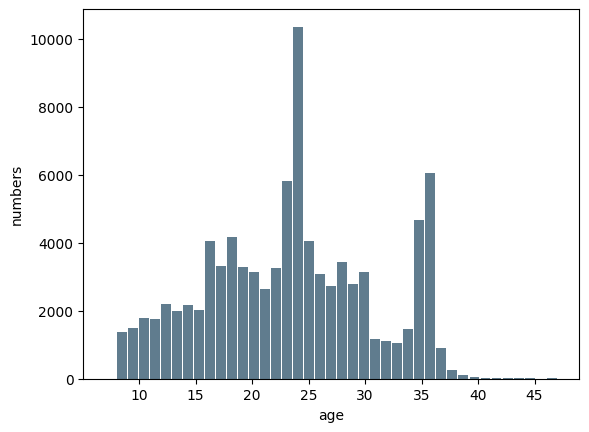

In [57]:
# 5. age
age_values=np.unique(data['age'])
print("There are a total{} of {} attributes, and their data share relationship is shown below.".format(len(age_values),"age"))
print("The relationship of the data is as follows：",Counter(data['age']))
commutes = data['age']
commutes.plot.hist( bins=len(age_values), rwidth=0.9,
                   color='#607c8e',align='mid')
plt.xlabel('age')
plt.ylabel('numbers')

plt.show()

In [76]:
# 6.comprehension
comprehension_values=np.unique(data['comprehension'])

print("There are a total{} of {} attributes, and their data share relationship is shown below.".format(len(comprehension_values),"comprehension"))

There are a total799 of comprehension attributes, and their data share relationship is shown below.


In [59]:
# 7. production
production_values=np.unique(data['production'])
print("There are a total {} of {} attributes, and their data share relationship is shown below.".format(len(production_values),"production"))

There are a total 799 of production attributes, and their data share relationship is shown below.


## 1.3 using sklearn calls to measure linear regression , DecisionTreeRegressor, and RandomForestRegressor

<!-- comprehension 和 production 可以考虑作为y值 -->

In [73]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
lm=linear_model.LinearRegression()
features=['comprehension']
X = data[features]
y = data['production']
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=41)
print(X.shape,y.shape)
model = lm.fit(x_train,y_train)
print(model.intercept_, model.coef_)
y_pred=model.predict(x_test)
#  y= -20.063717772708742 + 1.00629237*x

(90897, 1) (90897,)
-21.689956363258403 [0.98083898]


In [61]:
#MSE, RMSE, MAE, r2 using sklearn calls to measure linear regression
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("mean_absolute_error:", mean_absolute_error(y_test, y_pred)) # The range [0,+∞), which equals 0 when the predicted value exactly matches the true value, is the perfect model; the larger the error, the larger the value.
print("mean_squared_error:", mean_squared_error(y_test, y_pred)) #The range [0,+∞), which equals 0 when the predicted value exactly matches the true value, is the perfect model; the larger the error, the larger the value. 
print("rmse:", sqrt(mean_squared_error(y_test, y_pred))) #The range [0,+∞), which equals 0 when the predicted value exactly matches the true value, is the perfect model; the larger the error, the larger the value.
print("r2 score:", r2_score(y_test, y_pred))  # The closer the R2 is to 1, the better the model is!


mean_absolute_error: 39.58534650437028
mean_squared_error: 3817.1232267234163
rmse: 61.782871628983195
r2 score: 0.9096988517077516


In [68]:
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(random_state = 0)
tree_model=tree_regressor.fit(X, y)
print(model.intercept_, model.coef_)
y_pred=model.predict(x_test)

print("mean_absolute_error:", mean_absolute_error(y_test, y_pred)) 
print("mean_squared_error:", mean_squared_error(y_test, y_pred)) 
print("rmse:", sqrt(mean_squared_error(y_test, y_pred))) 
print("r2 score:", r2_score(y_test, y_pred)) 

-95.61838824208553 [11.41152941]
mean_absolute_error: 145.1619714959094
mean_squared_error: 34654.11065538384
rmse: 186.15614589742623
r2 score: 0.180192569283657


In [63]:
# See how age relates to comprehension and production respectively
lm=linear_model.LinearRegression()
features=['age']
X = data[features]
y = data['production']
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=41)
print(X.shape,y.shape)
model = lm.fit(x_train,y_train)
print(model.intercept_, model.coef_)
y_pred=model.predict(x_test)

print("mean_absolute_error:", mean_absolute_error(y_test, y_pred)) 
print("mean_squared_error:", mean_squared_error(y_test, y_pred)) 
print("rmse:", sqrt(mean_squared_error(y_test, y_pred))) 
print("r2 score:", r2_score(y_test, y_pred))  

(90897, 1) (90897,)
-95.61838824208553 [11.41152941]
mean_absolute_error: 145.1619714959094
mean_squared_error: 34654.11065538384
rmse: 186.15614589742623
r2 score: 0.180192569283657


In [69]:
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(random_state = 0)
tree_model=tree_regressor.fit(X, y)
print(model.intercept_, model.coef_)
y_pred=model.predict(x_test)

print("mean_absolute_error:", mean_absolute_error(y_test, y_pred)) 
print("mean_squared_error:", mean_squared_error(y_test, y_pred)) 
print("rmse:", sqrt(mean_squared_error(y_test, y_pred))) 
print("r2 score:", r2_score(y_test, y_pred)) 

-95.61838824208553 [11.41152941]
mean_absolute_error: 145.1619714959094
mean_squared_error: 34654.11065538384
rmse: 186.15614589742623
r2 score: 0.180192569283657


In [70]:
lm=linear_model.LinearRegression()
features=['age']
X = data[features]
y = data['comprehension']
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=41)
print(X.shape,y.shape)
model = lm.fit(x_train,y_train)
print(model.intercept_, model.coef_)
y_pred=model.predict(x_test)

print("mean_absolute_error:", mean_absolute_error(y_test, y_pred)) 
print("mean_squared_error:", mean_squared_error(y_test, y_pred))
print("rmse:", sqrt(mean_squared_error(y_test, y_pred))) 
print("r2 score:", r2_score(y_test, y_pred))  

(90897, 1) (90897,)
1.5654450902362385 [8.33875774]
mean_absolute_error: 156.24525628245445
mean_squared_error: 36137.85750872229
rmse: 190.09959891783646
r2 score: 0.10028798381915993


In [71]:
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(random_state = 0)
tree_model=tree_regressor.fit(X, y)
print(model.intercept_, model.coef_)
y_pred=model.predict(x_test)

print("mean_absolute_error:", mean_absolute_error(y_test, y_pred)) 
print("mean_squared_error:", mean_squared_error(y_test, y_pred)) 
print("rmse:", sqrt(mean_squared_error(y_test, y_pred))) 
print("r2 score:", r2_score(y_test, y_pred)) 

1.5654450902362385 [8.33875774]
mean_absolute_error: 156.24525628245445
mean_squared_error: 36137.85750872229
rmse: 190.09959891783646
r2 score: 0.10028798381915993


In [18]:
# Relationship of multiple features to comprehension and production
# age is_norming monolingual typically_developing

features=['age','is_norming','monolingual','typically_developing']
X = data[features]
y = data['comprehension']
# print(X.shape,y.shape)
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=41)
model = lm.fit(x_train,y_train)
print(model.intercept_, model.coef_)
y_pred=model.predict(x_test)

print("mean_absolute_error:", mean_absolute_error(y_test, y_pred))
print("mean_squared_error:", mean_squared_error(y_test, y_pred))
print("rmse:", sqrt(mean_squared_error(y_test, y_pred))) 
print("r2 score:", r2_score(y_test, y_pred))  

1.5874764065733302 [ 10.91274384 135.38067168 -50.73153889 -67.42371041]
mean_absolute_error: 145.14062468555576
mean_squared_error: 32005.03261557427
rmse: 178.89950423512713
r2 score: 0.20318152741783901


In [72]:
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(random_state = 0)
tree_model=tree_regressor.fit(X, y)
print(model.intercept_, model.coef_)
y_pred=model.predict(x_test)

print("mean_absolute_error:", mean_absolute_error(y_test, y_pred)) 
print("mean_squared_error:", mean_squared_error(y_test, y_pred)) 
print("rmse:", sqrt(mean_squared_error(y_test, y_pred))) 
print("r2 score:", r2_score(y_test, y_pred)) 

1.5654450902362385 [8.33875774]
mean_absolute_error: 156.24525628245445
mean_squared_error: 36137.85750872229
rmse: 190.09959891783646
r2 score: 0.10028798381915993


The random forest prediction shows that it is significantly better than the linear fit for the same data. 

In [19]:
from sklearn import ensemble
rf = ensemble.RandomForestRegressor(10)
model=rf.fit(x_train,y_train)
y_pred=model.predict(x_test)

print("mean_absolute_error:", mean_absolute_error(y_test, y_pred)) 
print("mean_squared_error:", mean_squared_error(y_test, y_pred)) 
print("rmse:", sqrt(mean_squared_error(y_test, y_pred))) 
print("r2 score:", r2_score(y_test, y_pred))

mean_absolute_error: 103.474570255774
mean_squared_error: 20144.47324003018
rmse: 141.93122714903222
r2 score: 0.4984698628214458


# 2. classification-"wordbank_instrument_data (1).csv"

In [20]:
# read csv file
# understands
import nltk,csv
data = pd.read_csv("wordbank_instrument_data (1).csv")
data=data[(data['value'] =="understands")| (data['value'] =="produces")]

num_columns=data.shape[1]
num_rows=data.shape[0]
print("There are {} data in total and {} columns".format(num_rows,num_columns))
print("The columns that need to be sorted are:item_definition")
print(data["item_definition"])
dataset=data["item_definition"]

There are 577456 data in total and 11 columns
The columns that need to be sorted are:item_definition
3          arehngry
4          aretired
5          becarefl
6           bequiet
7          claphand
             ...   
1925121         out
1925122       there
1925123       under
1925124          up
1925127        more
Name: item_definition, Length: 577456, dtype: object


In [21]:
word_list=data["item_definition"].tolist()
for i in range(len(word_list)):
#     print(word_list[i])
    if "(" in word_list[i]:
        word_list[i]=word_list[i].split("(")[0]
    if "*" in word_list[i]:
#         print(word_list[i])
        word_list[i]=word_list[i].split("*")[0]
    if " " in word_list[i]:
        word_list[i]=word_list[i].split(" ")[0]
#         print(word_list[i])
    if "/" in word_list[i]:
        word_list[i]=word_list[i].split("/")[0]
#         print(word_list[i])


In [22]:
catecory=[]
for k in range(len(word_list)):
    tokens = nltk.word_tokenize(word_list[k])
    pos_tags = nltk.pos_tag(tokens)
#     print(pos_tags[0][1])
    catecory.append(pos_tags[0][1])

In [23]:
# 1.	CC	Coordinating conjunction
# 2.	CD	Cardinal number	
# 3.	DT	Determiner
# 4.	EX	Existential there
# 5.	FW	Foreign word
# 6.	IN	Preposition or subordinating conjunction
# 7.	JJ	Adjective
# 8.	JJR	Adjective, comparative
# 9.	JJS	Adjective, superlative
# 10.	LS	List item marker
# 11.	MD	Modal
# 12.	NN	Noun, singular or mass
# 13.	NNS	Noun, plural
# 14.	NNP	Proper noun, singular
# 15.	NNPS	Proper noun, plural
# 16.	PDT	Predeterminer
# 17.	POS	Possessive ending
# 18.	PRP	Personal pronoun
# 19.	PRP$	Possessive pronoun
# 20.	RB	Adverb
# 21.	RBR	Adverb, comparative
# 22.	RBS	Adverb, superlative
# 23.	RP	Particle
# 24.	SYM	Symbol
# 25.	TO	to
# 26.	UH	Interjection
# 27.	VB	Verb, base form
# 28.	VBD	Verb, past tense
# 29.	VBG	Verb, gerund or present participle
# 30.	VBN	Verb, past participle
# 31.	VBP	Verb, non-3rd person singular present
# 32.	VBZ	Verb, 3rd person singular present
# 33.	WDT	Wh-determiner
# 34.	WP	Wh-pronoun
# 35.	WP$	Possessive wh-pronoun
# 36.	WRB	Wh-adverb

In [24]:
catecory=pd.DataFrame(catecory)
df = catecory.value_counts() 
data['new'] = catecory #Insert data into new column new
# data.to_csv(r"new1.csv",mode = 'a',index =False)
# path=r"new1.csv"
# data=pd.read_csv(path)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times


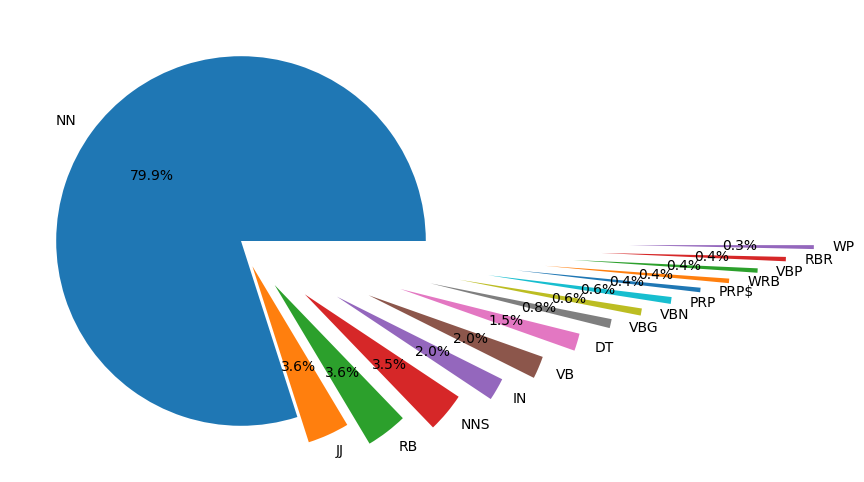

In [25]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']='Times'
plt.figure(figsize=(6,6))
label=df.index
new_label=[]
for n in range(len(label)):
#     print(label[n][0])
    new_label.append(label[n][0])
explode=np.zeros(len(new_label))# Set each item to n radii from the centre of the circle
for n in range(len(explode)):
    explode[n]=0.15*n
values=df.to_list()
plt.pie(values,explode=explode,labels=new_label,autopct='%1.1f%%')
plt.show()

### The ability to learn different categories of words at different ages

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Times


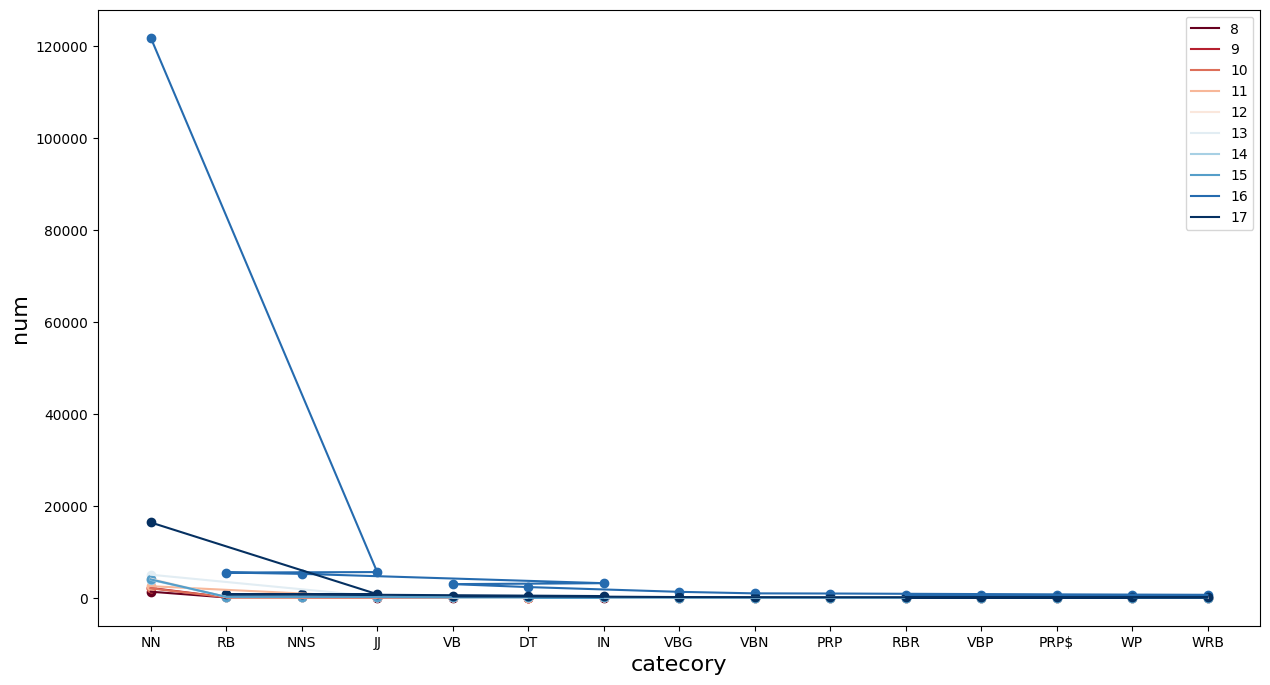

In [26]:
import matplotlib.pyplot as plt
age=sorted(np.unique(data["age"].to_list())[:-1])
age_sorted=[]
for k in age:
    age_sorted.append(int(k))
age_sorted=sorted(age_sorted)

colors = plt.get_cmap('RdBu',len(age_sorted)*2)
plt.figure(figsize=(15, 8), dpi=100)

for a in range(len(age_sorted)):
    Age=data[data['age'] == int(age_sorted[a])]["new"].value_counts() 
    game = Age.index
    scores = Age.to_list()

#     new_scores=[]
#     for n in scores:
#         new_scores.append(n/sum(scores))
#     print(new_scores)
    plt.plot(game, scores,label=age_sorted[a], c=plt.get_cmap('RdBu',10)([a]))
    plt.scatter(game,scores,c=plt.get_cmap('RdBu',10)([a]))
    plt.yticks()
#     o=1
#     if age_sorted[a]==15 or age_sorted[a]==13 or age_sorted[a]==17:
#         o=2
#     if age_sorted[a]==17:
#         o=3
#     plt.annotate(age_sorted[a],#文本内容
#          xy=(scores[0],game[0]),#注释所在地
#          xytext=(scores[0], scores[0]), fontsize=16,#文本所在地
#          arrowprops=dict(arrowstyle="->"))#注释和文本的连接方式，具体的可以通过?plt.annotate弹出的para查看

plt.xlabel("catecory", fontdict={'size': 16})
plt.ylabel("num", fontdict={'size': 16})
plt.legend()
plt.show()

In [27]:
all=np.zeros((len(Age),len(age_sorted)))
# print(al

In [28]:
for a in range(len(age_sorted)):
    Age=data[data['age'] == int(age_sorted[a])]["new"].value_counts() 
    game = Age.index
#     print(game)
    tmp=[]
    # Age=Age.to_list()
    for p in range(len(Age)):
        all[p,a]=Age[p]


In [29]:
label

MultiIndex([(  'NN',),
            (  'JJ',),
            (  'RB',),
            ( 'NNS',),
            (  'IN',),
            (  'VB',),
            (  'DT',),
            ( 'VBG',),
            ( 'VBN',),
            ( 'PRP',),
            ('PRP$',),
            ( 'WRB',),
            ( 'VBP',),
            ( 'RBR',),
            (  'WP',)],
           )

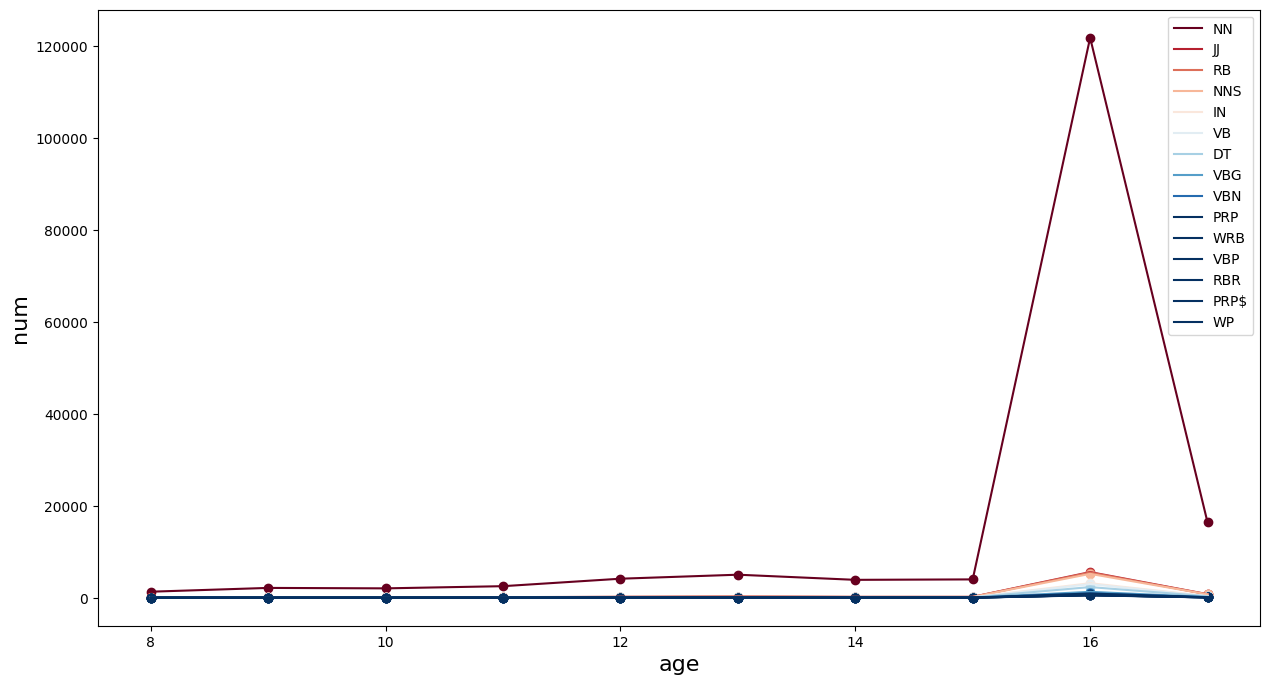

In [30]:
# all
colors = plt.get_cmap('RdBu',len(Age.index)*2)
plt.figure(figsize=(15, 8), dpi=100)
for a in range(len(Age.index)):
#     print(Age.index[a])
    game = all[a,:]
    scores =age_sorted
    plt.plot(scores, game,label=Age.index[a], c=plt.get_cmap('RdBu',10)([a]))
    plt.scatter(scores, game,c=plt.get_cmap('RdBu',10)([a]))
    plt.yticks()

plt.xlabel("age", fontdict={'size': 16})
plt.ylabel("num", fontdict={'size': 16})
plt.legend()
plt.show()
    

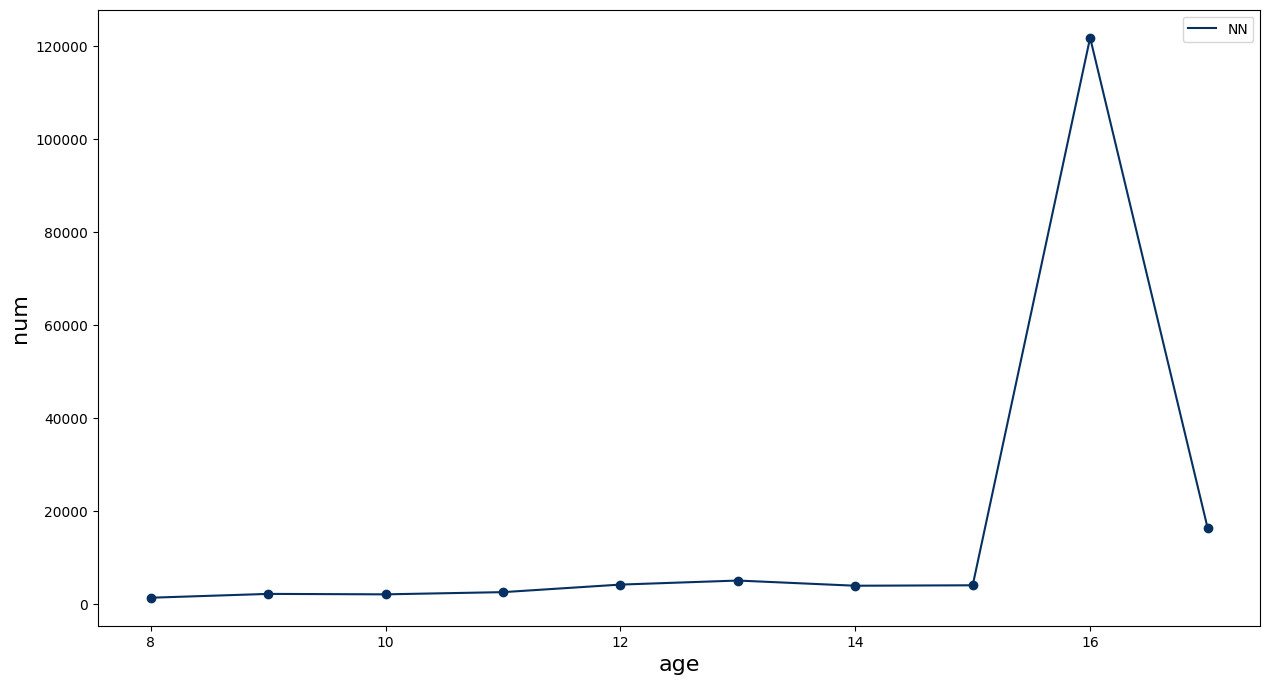

In [31]:
# all
colors = plt.get_cmap('RdBu',len(Age.index)*2)
plt.figure(figsize=(15, 8), dpi=100)

game = all[0,:]
scores =age_sorted
plt.plot(scores, game,label=Age.index[0], c=plt.get_cmap('RdBu',10)([a]))
plt.scatter(scores, game,c=plt.get_cmap('RdBu',10)([a]))
plt.yticks()

plt.xlabel("age", fontdict={'size': 16})
plt.ylabel("num", fontdict={'size': 16})
plt.legend()
plt.show()

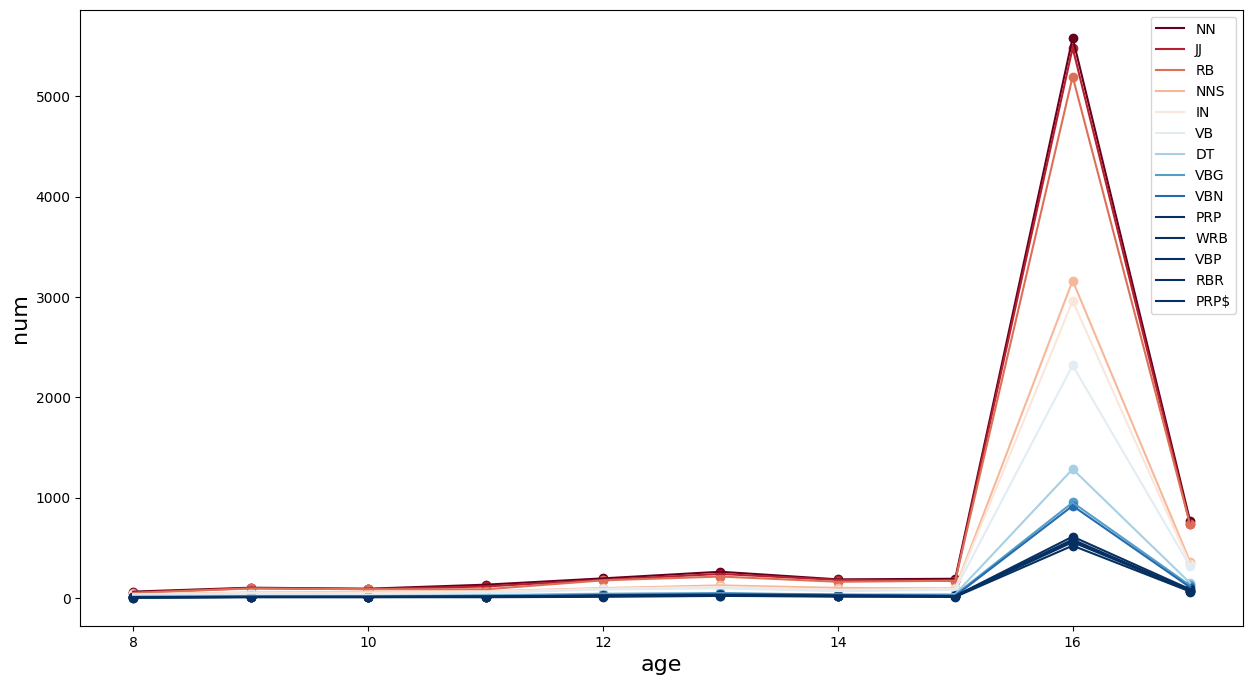

In [32]:
# all
colors = plt.get_cmap('RdBu',len(Age.index)*2)
plt.figure(figsize=(15, 8), dpi=100)

for a in range(len(Age[1:].index)):
#     print(Age.index[a])
    game = all[1:,:][a,:]
    scores =age_sorted
    plt.plot(scores, game,label=Age.index[a], c=plt.get_cmap('RdBu',10)([a]))
    plt.scatter(scores, game,c=plt.get_cmap('RdBu',10)([a]))
    plt.yticks()

plt.xlabel("age", fontdict={'size': 16})
plt.ylabel("num", fontdict={'size': 16})
plt.legend()
plt.show()
    

In [33]:
all.shape

(15, 10)

In [34]:
age_sorted[1:]

[9, 10, 11, 12, 13, 14, 15, 16, 17]

In [35]:
# read csv file
import nltk,csv
data1 = pd.read_csv("wordbank_item_data (1).csv")

num_columns=data1.shape[1]
num_rows=data1.shape[0]
print("There are {} data in total and {} columns".format(num_rows,num_columns))
print("The columns that need to be sorted are:item_definition")
print(data1["item_definition"])
dataset1=data["item_definition"]

There are 680 data in total and 19 columns
The columns that need to be sorted are:item_definition
0             baa baa
1           choo choo
2      cockadoodledoo
3                grrr
4                meow
            ...      
675           because
676               but
677                if
678                so
679              then
Name: item_definition, Length: 680, dtype: object


In [36]:
word_list1=data1["item_definition"].tolist()
for i in range(len(word_list1)):
#     print(word_list[i])
    if "(" in word_list1[i]:
        word_list1[i]=word_list1[i].split("(")[0]
    if "*" in word_list1[i]:
#         print(word_list[i])
        word_list1[i]=word_list1[i].split("*")[0]
    if " " in word_list1[i]:
        word_list1[i]=word_list1[i].split(" ")[0]
#         print(word_list[i])
    if "/" in word_list1[i]:
        word_list1[i]=word_list1[i].split("/")[0]
#         print(word_list[i])
        

In [37]:
catecory1=[]
for k in range(len(word_list1)):
    tokens1 = nltk.word_tokenize(word_list1[k])
    pos_tags1 = nltk.pos_tag(tokens1)
#     print(pos_tags[0][1])
    catecory1.append(pos_tags1[0][1])

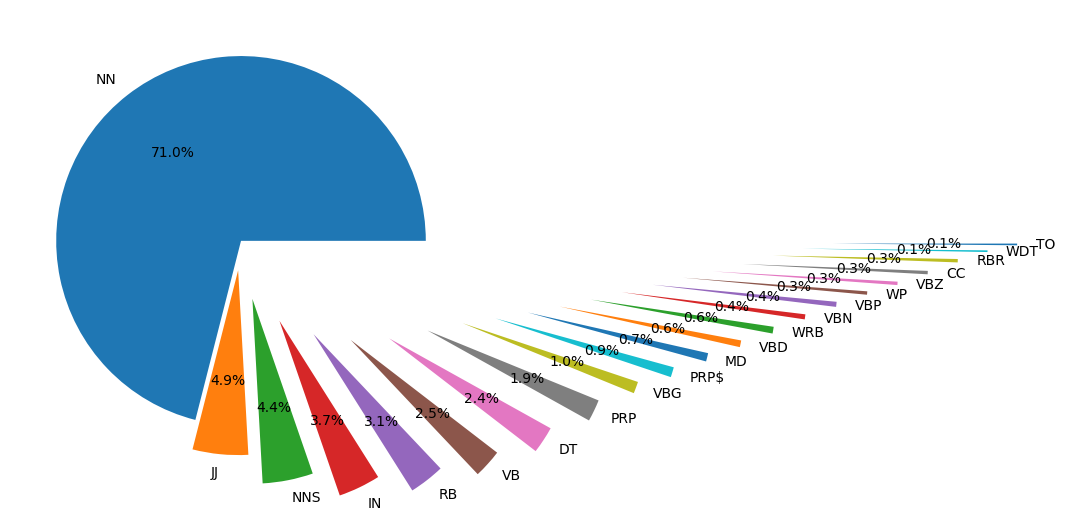

In [38]:
catecory1=pd.DataFrame(catecory1)
df1 = catecory1.value_counts() 
data1['new'] = catecory1 #Insert data into new column new
data1.to_csv(r"new2.csv",mode = 'a',index =False)
path1=r"new2.csv"
data1=pd.read_csv(path1)

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']='Times'
plt.figure(figsize=(6,6))
label1=df1.index
new_label1=[]
for n in range(len(label1)):
#     print(label1[n][0])
    new_label1.append(label1[n][0])
explode=np.zeros(len(label1))# Set each item to n radii from the centre of the circle
for n in range(len(explode)):
    explode[n]=0.16*n
values=df1.to_list()
plt.pie(values,explode=explode,labels=new_label1,autopct='%1.1f%%')
plt.show()

In [39]:
# read csv file
# produces
import nltk,csv
data = pd.read_csv("wordbank_instrument_data (1).csv")
data=data[data['value'] =="produces"]

num_columns=data.shape[1]
num_rows=data.shape[0]
print("There are {} data in total and {} columns".format(num_rows,num_columns))
print("The columns that need to be sorted are:item_definition")
print(data["item_definition"])
dataset=data["item_definition"]

There are 124090 data in total and 11 columns
The columns that need to be sorted are:item_definition
33          baa baa
36             grrr
37             meow
38              moo
41            uh oh
             ...   
1925045      tickle
1925060    all gone
1925087      pretty
1925116        down
1925127        more
Name: item_definition, Length: 124090, dtype: object


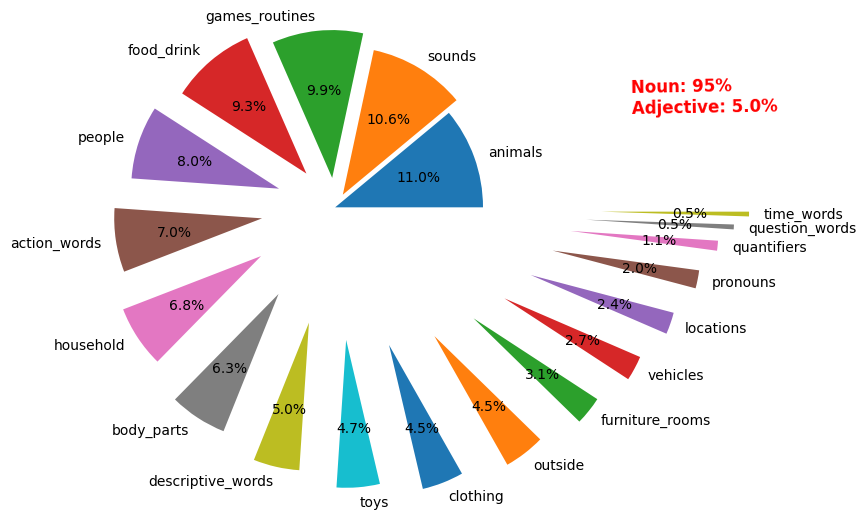

In [44]:
p=data["category"].value_counts()
explode=np.zeros(len(p.index))# Set each item to n radii from the centre of the circle
for n in range(len(explode)):
    explode[n]=0.1*n

plt.pie(p.values,explode=explode,labels=p.index,autopct='%1.1f%%')
plt.text(x=2,#文本x轴坐标 
         y=0.5, #文本y轴坐标
         s='Noun: 95%\nAdjective: 5.0%\n', #文本内容
         rotation=1,#文字旋转
         ha='left',#x=2.2是文字的左端位置，可选'center', 'right', 'left'
         va='baseline',#y=8是文字的低端位置，可选'center', 'top', 'bottom', 'baseline', 'center_baseline'
         fontdict=dict(fontsize=12, color='r',
                       family='Times',#字体,可选'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'
                       weight='bold',#磅值，可选'light', 'normal', 'medium', 'semibold', 'bold', 'heavy', 'black'
                      
                      )#字体属性设置
        )
plt.show()